In [20]:
import numpy as np
import pandas as pd
import random
import time
import pickle
from joblib import Parallel, delayed

from opendp.whitenoise.synthesizers.base import SDGYMBaseSynthesizer

class dumb_predictor():
    """
    Dummy classifier to be used if any of conf.KNOWN_MODELS break.
    Returns single class as prediction.
    """
    def __init__(self, label):
        self.label = label
        
    def predict(self, instances):
        return np.full(len(instances), self.label)

class SuperQUAILSynthesizer(SDGYMBaseSynthesizer):
    """
    Quailified Architecture to Improve Labeling.

    Divide epsilon in a known classification task
    between a differentially private synthesizer and
    classifier. Train DP classifier on real, fit DP synthesizer
    to features (excluding the target label)
    and use synthetic data from the DP synthesizer with
    the DP classifier to create artificial labels. Produces
    complete synthetic data
    """
    
    def __init__(self, epsilon, dp_classifier, class_args, test_size=0.2, seed=42, eps_split=0.9):
        self.epsilon = epsilon
        self.eps_split = eps_split
        self.dp_classifier = dp_classifier
        self.class_args = class_args
        self.test_size = test_size
        self.seed = seed
        
        # Model
        self.private_models = None
        self.private_synth = None
        
        # Pandas check
        self.pandas = False
        self.pd_cols = None
        self.pd_index = None

        self.continuous_ranges = None
        self.categorical_ranges = None
        self.ordinal_ranges = None
        
    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import classification_report
        from sklearn.metrics import accuracy_score
        
        if isinstance(data, pd.DataFrame):
            self.pandas = True
            for col in data.columns:
                data[col] = pd.to_numeric(data[col], errors='ignore')
            self.data = data
            self.pd_cols = data.columns
            self.pd_index = data.index
        else:
            raise('Only pandas dataframes for data as of now.')

        self.private_models = {}
        eps_per_column = self.epsilon / float(len(data.columns) + 1)
        
        self.continuous_ranges = {}
        self.categorical_ranges = {}
        self.ordinal_ranges = {}

        for c in categorical_columns:
            # TODO: Delve into this
            # Pretty sure its safe to just grab all the possible categories
            # print(data[c])
            self.categorical_ranges[c] = np.unique(data[c])

        for c in ordinal_columns:
            # We do same thing we do for ordinal
            self.ordinal_ranges[c] = (int(self._report_noisy_max_min(data[c], eps_per_column, 'min')),
                                        int(self._report_noisy_max_min(data[c], eps_per_column, 'max')))

        for c in data.columns:
            ## Take care of continuous column distribution ranges here
            # print('Training model for ' +  c)
            if c not in list(categorical_columns) + list(ordinal_columns):
                self.continuous_ranges[c] = (self._report_noisy_max_min(data[c], eps_per_column, 'min'),
                                        self._report_noisy_max_min(data[c], eps_per_column, 'max'))

            ## Train Model
            features = data.loc[:, data.columns != c]
            target = data.loc[:, data.columns == c]
            x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=self.test_size, random_state=self.seed)
            try:
                private_model = self.dp_classifier(epsilon=eps_per_column, **self.class_args)
                private_model.fit(x_train, y_train.values.ravel())
#                 predictions = self.private_model.predict(x_test)
#                 self.class_report = classification_report(np.ravel(y_test), predictions, labels=np.unique(predictions))
#                 self.target_accuracy = accuracy_score(np.ravel(y_test), predictions)
            except:
                print('Unsuccessful when training model for ' +  c + ', using dumb_predictor.')
                y, counts = np.unique(y_train.values.ravel(), return_counts=True)
                label = y[np.argmax(counts)]
                private_model = dumb_predictor(label)
                
            
            if c not in self.private_models:
                self.private_models[c] = private_model
            else:
                raise ValueError("Duplicate column model built.")

    def sample(self, samples):

        def _a_sample(arg):
            index, sample_shape = arg
            sample = np.empty(sample_shape)
            shuffled_column_indexes = np.arange(len(self.data.columns))
            np.random.shuffle(shuffled_column_indexes)
            
            shuffled_columns = self.data.columns[shuffled_column_indexes]
            reordered = self._reorder(shuffled_column_indexes)
            for i, c in enumerate(shuffled_columns):
                pred_sample = np.empty(sample_shape)
                pred_sample[:] = None
                for j, col in enumerate(shuffled_columns):
                    if c != col:
                        if sample[j]:
                            pred_sample[j] = sample[j]
                        else:
                            if col in self.continuous_ranges:
                                pred_sample[j] = np.random.uniform(self.continuous_ranges[col][0],
                                                                    self.continuous_ranges[col][0],1)
                            elif col in self.ordinal_ranges:
                                pred_sample[j] = np.random.randint(self.ordinal_ranges[col][0],
                                                                    self.ordinal_ranges[col][1] + 1)
                            elif col in self.categorical_ranges:
                                pred_sample[j] = np.random.choice(self.categorical_ranges[col],1)
                pred_sample = pred_sample[pred_sample != np.array(None)]
                pred_sample = pred_sample[~np.isnan(pred_sample)]
                # print(c)
                # print(pred_sample)
                c_pred = self.private_models[c].predict(pred_sample.reshape(1, -1))
                sample[i] = c_pred
                break
            return sample[reordered]

        start = time.time()
        job_num = 10
        sample_shape = self.data.iloc[0].shape

        runs = [(i, sample_shape) for i in range(samples)]
        #_a_sample(runs[0])
        results = Parallel(n_jobs=job_num, verbose=1, backend="loky")(
            map(delayed(_a_sample), runs))
        end = time.time() - start
        # print('Sampling took ' + str(end))

        return pd.DataFrame(np.array(results), columns = self.data.columns)
        

    def _report_noisy_max_min(self, set, epsilon, min_or_max='max'):
        best = 0
        r = 0
        for i,d in enumerate(set):
            d = d + self._laplace(epsilon)
            if min_or_max == 'min':
                if d < best:
                    r = i
            elif min_or_max == 'max':
                if d > best:
                    r = i
            else:
                raise ValueError('Must specify either min or max.')
        return r
    
    def _laplace(self, sigma):
        """
        Laplace mechanism

        :param sigma: Laplace scale param sigma
        :type sigma: float
        :return: Random value from laplace distribution [-1,1]
        :rtype: float
        """
        return sigma * np.log(random.random()) * np.random.choice([-1, 1])
    
    def _reorder(self, splits):
        """
        Given an array of dimensionality splits (column indices)
        returns the corresponding reorder array (indices to return
        columns to original order)

        Example:
        original = [[1, 2, 3, 4, 5, 6],
        [ 6,  7,  8,  9, 10, 11]]
        
        splits = [[1,3,4],[0,2,5]]
        
        mod_data = [[2 4 5 1 3 6]
                [ 7  9 10  6  8 11]]
        
        reorder = [3 0 4 1 2 5]

        :param splits: 2d list with splits (column indices)
        :type splits: array of arrays
        :return: 2d list with splits (column indices)
        :rtype: array of arrays
        """
        flat = splits.ravel()
        reordered = np.zeros(len(flat))
        for i, ind in enumerate(flat):
            reordered[ind] = i
        return reordered.astype(int)

In [21]:
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from load_data import load_data

loaded_datasets = load_data()

Memory consumed by car:96896


In [22]:
quail = SuperQUAILSynthesizer(1.0, DPLR, {'max_iter': 1000})

In [23]:
quail.fit(loaded_datasets['car']['data'], categorical_columns="buying,maint,doors,persons,lug_boot,safety,class".split(','))

/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:222: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:222: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8

In [24]:
samples = quail.sample(len(loaded_datasets['car']['data']))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done 1350 tasks      | elapsed:   17.1s
[Parallel(n_jobs=10)]: Done 1728 out of 1728 | elapsed:   17.5s finished


In [25]:
def test_real_vs_synthetic_data(real, synthetic, model, tsne=False, box=False, describe=False):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    
    synth_df = pd.DataFrame(synthetic, 
        index=real.index,
        columns=real.columns)

    X = real.iloc[:, :-1]
    y = real.iloc[:, -1]
    X_synth = synth_df.iloc[:, :-1]
    y_synth = synth_df.iloc[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train_synth, x_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=0.2, random_state=42)
    
    model_real = model()
    model_real.fit(x_train, y_train)

    model_fake = model()
    model_fake.fit(x_train_synth, y_train_synth)
    
    #Test the model
    predictions = model_real.predict(x_test)
    print()
    print('Trained on Real Data')
    print(classification_report(y_test, predictions))
    print('Accuracy real: ' + str(accuracy_score(y_test, predictions)))
    
    predictions = model_fake.predict(x_test)
    print()
    print('Trained on Synthetic Data')
    print(classification_report(y_test, predictions))
    print('Accuracy synthetic: ' + str(accuracy_score(y_test, predictions)))

    # How does it compare to guessing randomly?
    print()
    print('Random Guessing')
    guesses = np.random.randint(0,(max(y_test_synth)-min(y_test_synth) + 1),len(y_test_synth))
    np.random.shuffle(guesses)
    print(classification_report(y_test_synth, guesses))
    print('Accuracy guessing: ' + str(accuracy_score(y_test_synth, guesses)))

    # TSNE Plot
    if tsne:
        from sklearn.manifold import TSNE
        comb = np.vstack((x_train[:500], x_train_synth[:500]))
        embedding_1 = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0).fit_transform(comb)
        x,y = embedding_1.T
        l = int(len(x) / 2)
        inds = []

        plt.rcParams["figure.figsize"] = (15,15)
        plt.scatter(x,y,c=['purple' if i in inds else 'red' for i in range(l)]+['purple' if j in inds else 'blue' for j in range(l)])
        plt.gca().legend(('Real Data','Real'))
        plt.title('TSNE Plot, Real Data vs. Synthetic')
        plt.show()

    # Box plot
    if box:
        import math
        import seaborn as sns
        fig = plt.figure(figsize=(20,15))
        cols = 5
        rows = math.ceil(float(real.shape[1]) / cols)
        for i, column in enumerate(real.columns):
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.set_title(column)
            sns.boxplot(data=[real[column], synth_df[column]])
        plt.subplots_adjust(hspace=0.7, wspace=0.2)

    if describe:
        print(real.describe())
        print(synth_df.describe())

    return model_real, model_fake


Trained on Real Data
              precision    recall  f1-score   support

           0       0.26      0.13      0.18        83
           1       0.00      0.00      0.00        11
           2       0.72      0.92      0.81       235
           3       0.00      0.00      0.00        17

    accuracy                           0.66       346
   macro avg       0.25      0.26      0.25       346
weighted avg       0.55      0.66      0.59       346

Accuracy real: 0.6589595375722543

Trained on Synthetic Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.00      0.00      0.00        11
           2       0.60      0.71      0.65       235
           3       0.00      0.00      0.00        17

    accuracy                           0.49       346
   macro avg       0.15      0.18      0.16       346
weighted avg       0.41      0.49      0.44       346

Accuracy synthetic: 0.48554913294797686

Random

/home/lurosenb/anaconda3/envs/oss_dp_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


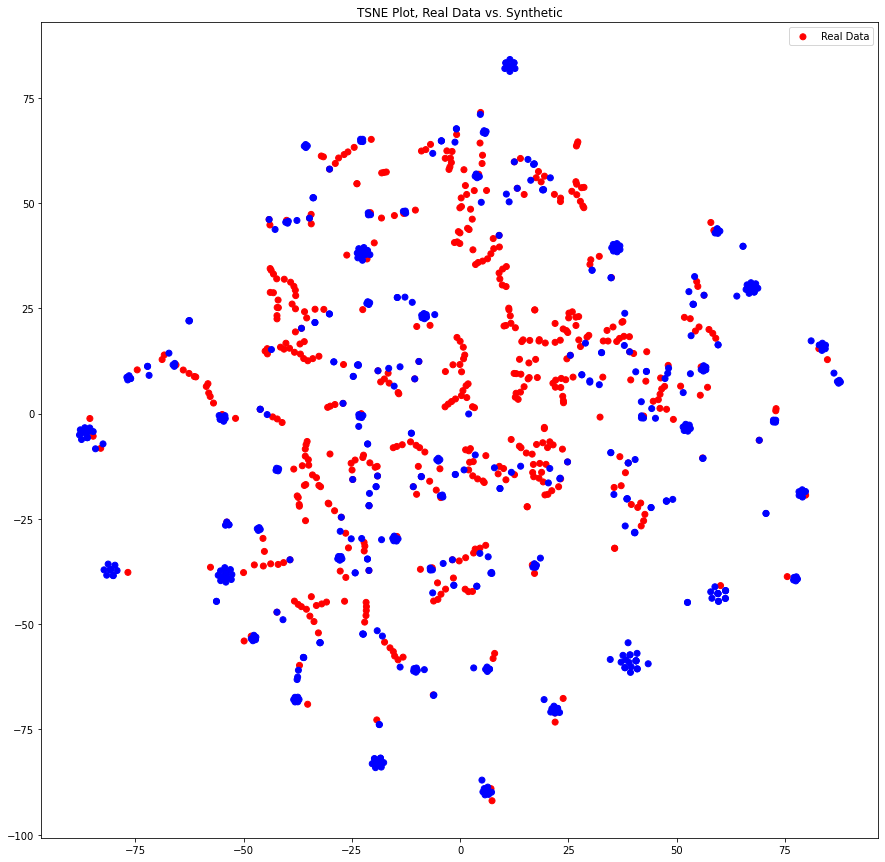

            buying        maint        doors      persons     lug_boot  \
count  1728.000000  1728.000000  1728.000000  1728.000000  1728.000000   
mean      1.500000     1.500000     1.500000     1.000000     1.000000   
std       1.118358     1.118358     1.118358     0.816733     0.816733   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.750000     0.750000     0.750000     0.000000     0.000000   
50%       1.500000     1.500000     1.500000     1.000000     1.000000   
75%       2.250000     2.250000     2.250000     2.000000     2.000000   
max       3.000000     3.000000     3.000000     2.000000     2.000000   

            safety        class  
count  1728.000000  1728.000000  
mean      1.000000     1.553241  
std       0.816733     0.875948  
min       0.000000     0.000000  
25%       0.000000     1.000000  
50%       1.000000     2.000000  
75%       2.000000     2.000000  
max       2.000000     3.000000  
            buying        m

(LogisticRegression(), LogisticRegression())

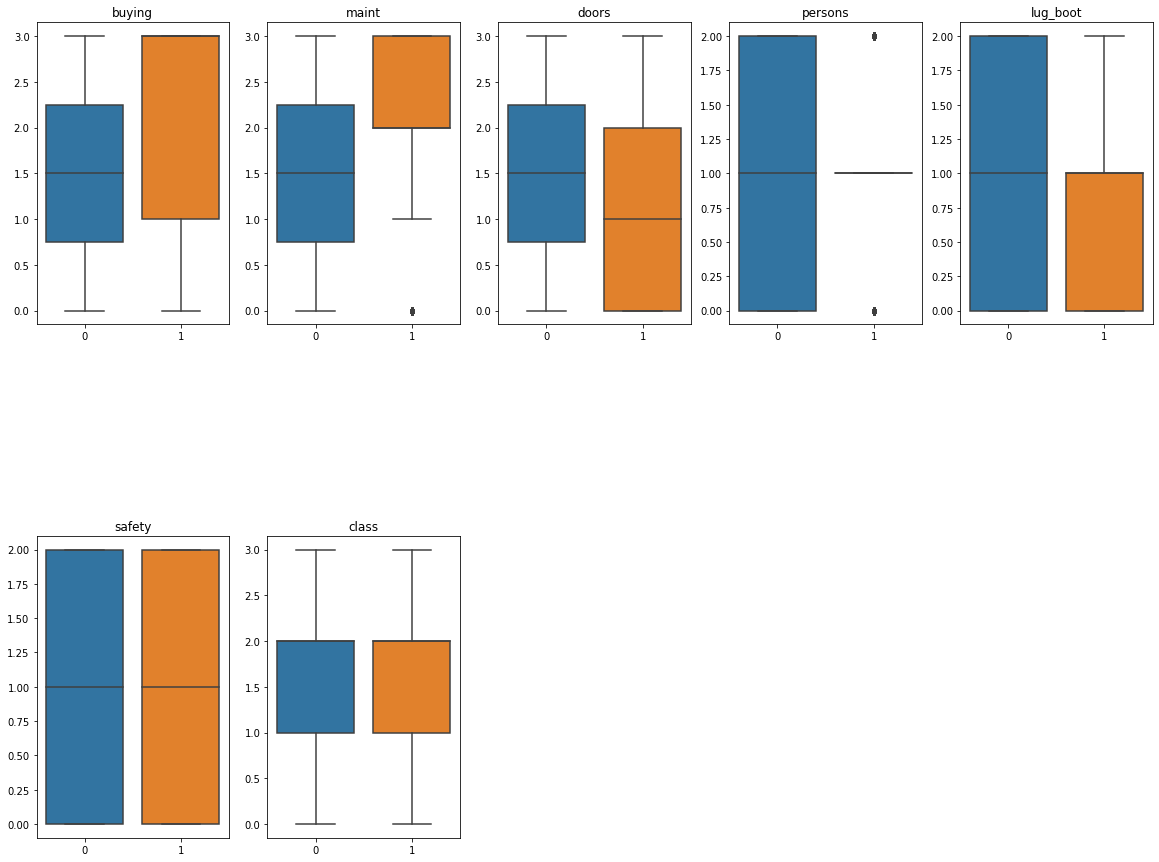

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
test_real_vs_synthetic_data(loaded_datasets['car']['data'], samples, LogisticRegression, tsne=True, box=True, describe=True)